In [1]:
import genfig

# Installation via pip install -e ./genfig

# Note: genfig currently has pygraphviz as a dependency, which is a bit tricky to install on mac.
# to install pygraphviz on macOS, you need to first install graphviz using homebrew,
# and then tell pip to look for the graphviz headers and libraries in the homebrew directory:
#  brew install graphviz
#  python3 -m pip install \
#                --config-settings="--global-option=build_ext" \
#                --config-settings="--global-option=-I$(brew --prefix graphviz)/include/" \
#                --config-settings="--global-option=-L$(brew --prefix graphviz)/lib/" \
#                pygraphviz

# TODO:
# - use pydot instead of pygraphviz to render the graph, as pydot is a pure python library and is easier to install
# - move the SVG rendering to a git pre-commit hook so that people can change DOT files directly without needing
# to run this script to see the changes.

In [2]:
from IPython.display import Image, SVG

# A small function that dynamically displays a bytestring as png or svg
def show(data):
    # If we got passed anything else, try displaying it directly
    if type(data) != bytes:
        display(data) 
    # SVG
    elif data.startswith(b'<?xml'):
        display(SVG(data))
    # Bitmap
    else:
        display(Image(data))


# README

## Figure 1 & 2

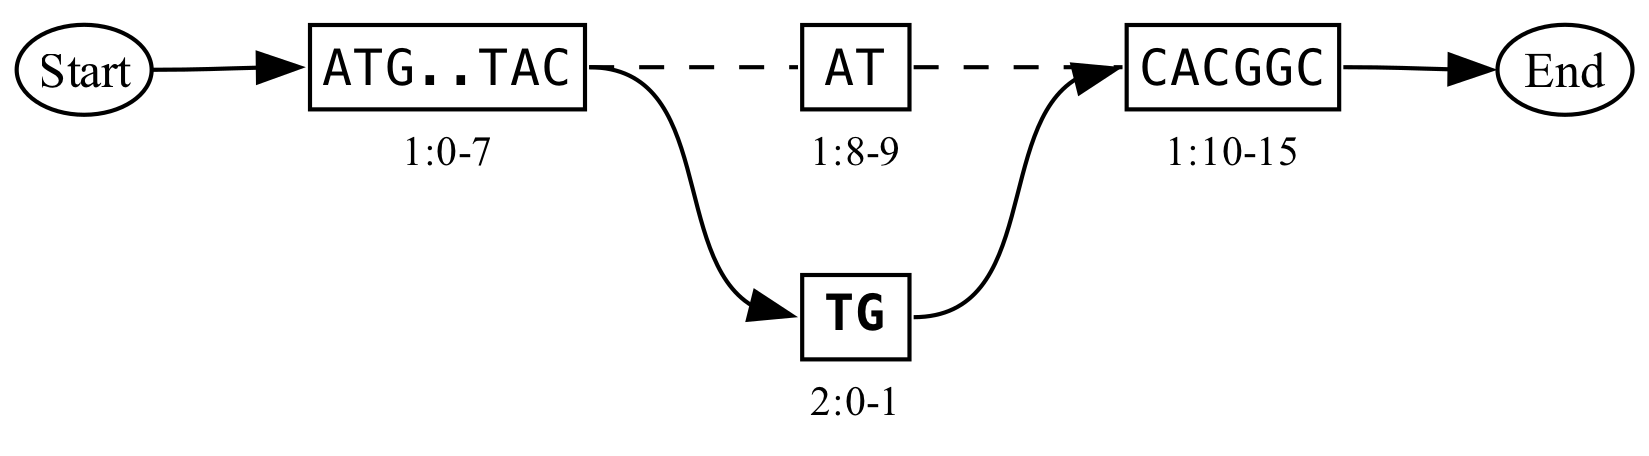

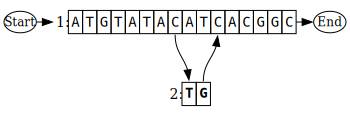

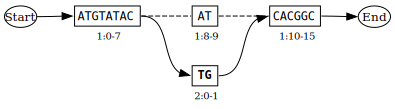

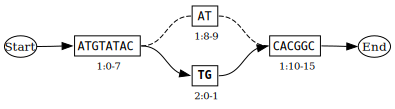

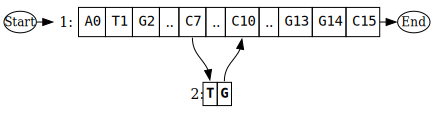

In [3]:
G = genfig.Graph()

n1 = G.add_node('ATGTATACATCACGGC') # Derived from BBa_K1896001
n2 = G.add_node('TG')
G.connect_to_source(n1)
G.connect_to_sink(n1)
G.add_edge((n1, 7), (n2, 0))
G.add_edge((n2, 1), (n1, 10))
#G.highlight_ranges(n1, [(0, 8), (10, 16)])
#G.highlight_ranges(n1, [(0, 8), (10, 16)])
G.highlight_ranges(n2, [(0, 2)])
show(G)

show(G.render_graph('figure_1.svg', minimize=False))
show(G.render_block_graph('figure_2.svg', minimize=False))
show(G.render_block_graph('figure_2_symmetrical.svg', minimize=False, align_blocks=False))

show(G.render_graph(minimize=True))

# Examples

## Protein Engineering

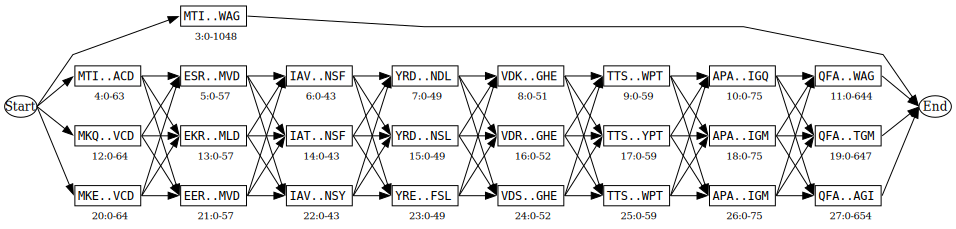

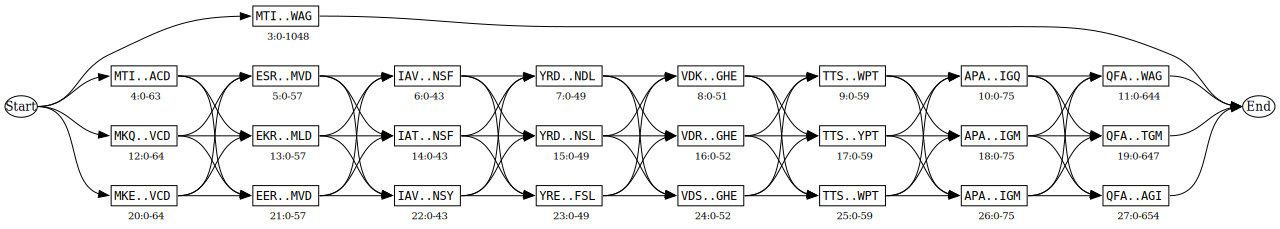

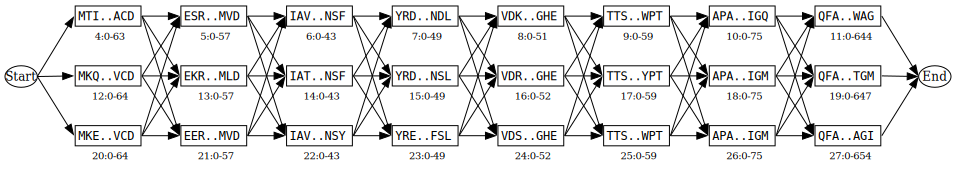

In [4]:
db_file = '../../examples/protein_engineering/protein_engineering.db'

G = genfig.Graph(db=db_file)
show(G.render_block_graph('protein_figure_1.svg', minimize=True, splines=False))
#G.render_block_graph(minimize=True, splines=True)
show(G.render_block_graph(minimize=True, splines=True, graph_attributes={'ranksep':'1'}))

show(G.render_block_graph(minimize=True, splines=False, hide_nodes=['3.0']))

#G.render_graph(minimize=True, splines=False)
#G.render_graph(minimize=True, splines=False, graph_attributes={'rankdir':'LR'}, hide_nodes=['start', 'end'])


